In [1]:
# Standard library imports
import os
import datetime
import pickle
import warnings

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from colorama import Fore, Style
import xgboost
from scipy.stats import mannwhitneyu
import scipy.special
from catboost import CatBoostClassifier
import category_encoders as ce

# Scikit-learn imports
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, accuracy_score
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Configure pandas to display more columns
pd.set_option('display.max_columns', 200)
np.random.seed(7) 

# First step - looking at data

In [2]:
# Load dataset
df = pd.read_csv('data.csv')
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [3]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,10.960895,11.032324,126.978119,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,26.418253,25.263040,14.482001,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,4.000000,4.000000,117.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,5.000000,7.000000,126.100000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,134.800000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


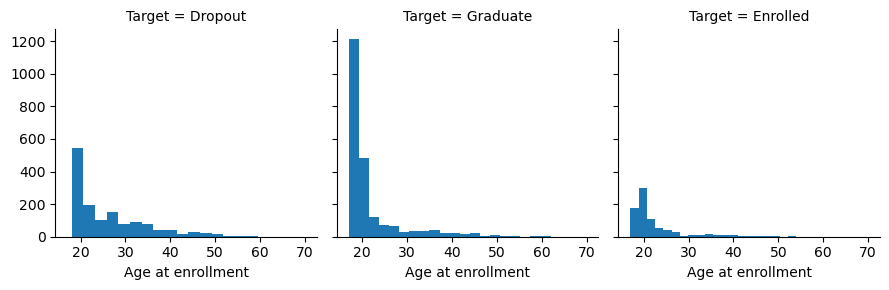

In [4]:
# Plot distribution of 'Age at enrollment' by 'Target'
g = sns.FacetGrid(df, col='Target')
g.map(plt.hist, 'Age at enrollment', bins=20)


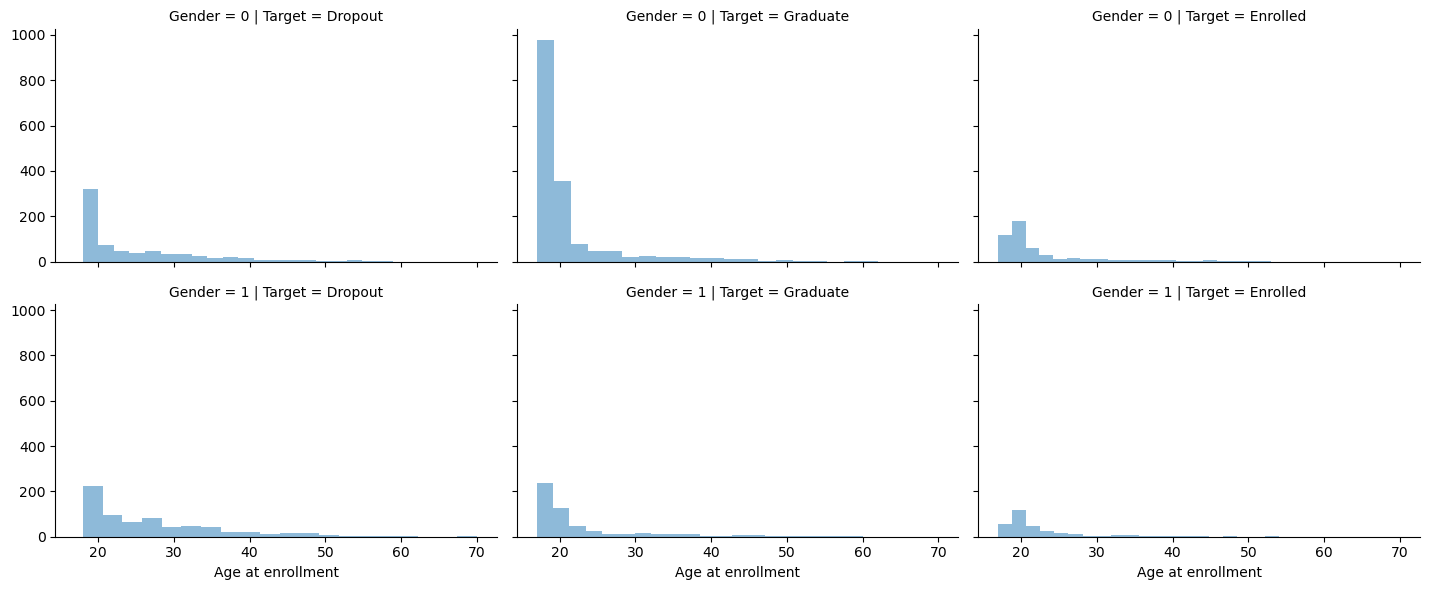

In [5]:
# Plot distribution of 'Age at enrollment' by 'Target' and 'Gender'
grid = sns.FacetGrid(df, col='Target', row='Gender', aspect=1.6)
grid.map(plt.hist, 'Age at enrollment', alpha=.5, bins=20)
grid.add_legend()


* Some data (Marital status, Application order, Course, Previous qualification, etc) seems ordial but it is not. For example, Marital status: 1 – single 2 – married 3 – widower 4 – divorced 5 – facto union 6 – legally separated. For such columns, we should create a one hot encoding or not to use them

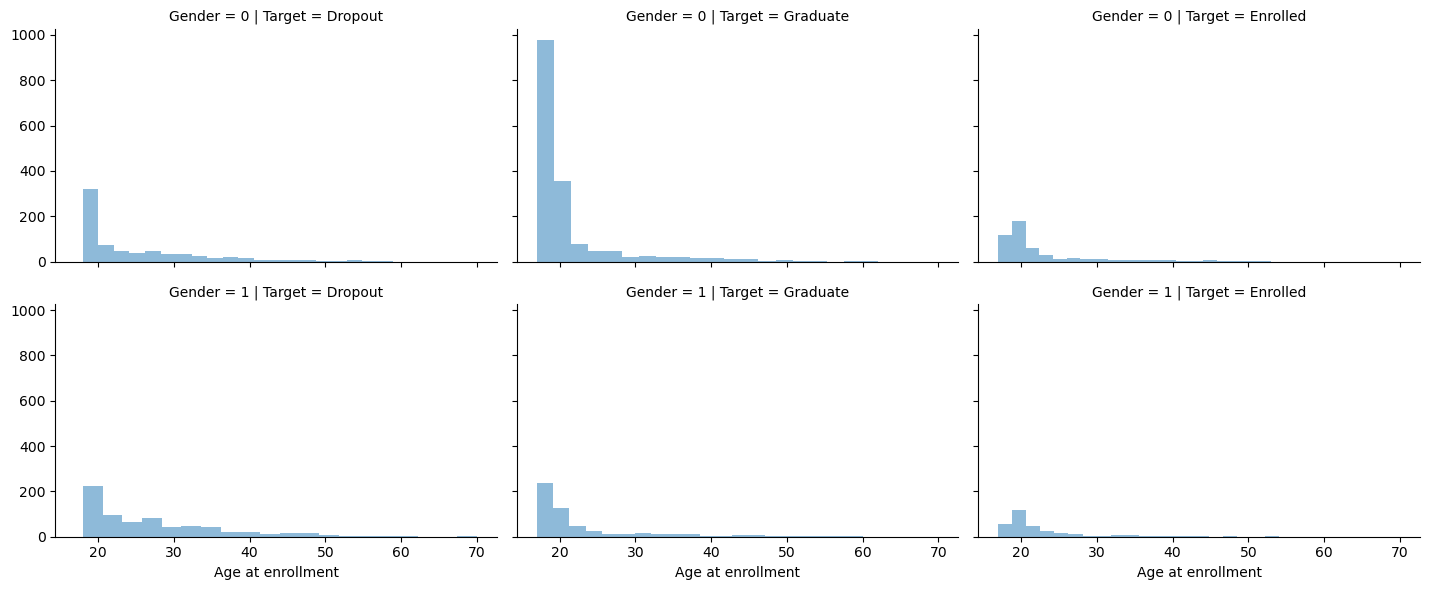

In [6]:
grid = sns.FacetGrid(df, col='Target', row='Gender', aspect=1.6)
grid.map(plt.hist, 'Age at enrollment', alpha=.5, bins=20)
grid.add_legend();

/tmp/ipykernel_129007/2735414555.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


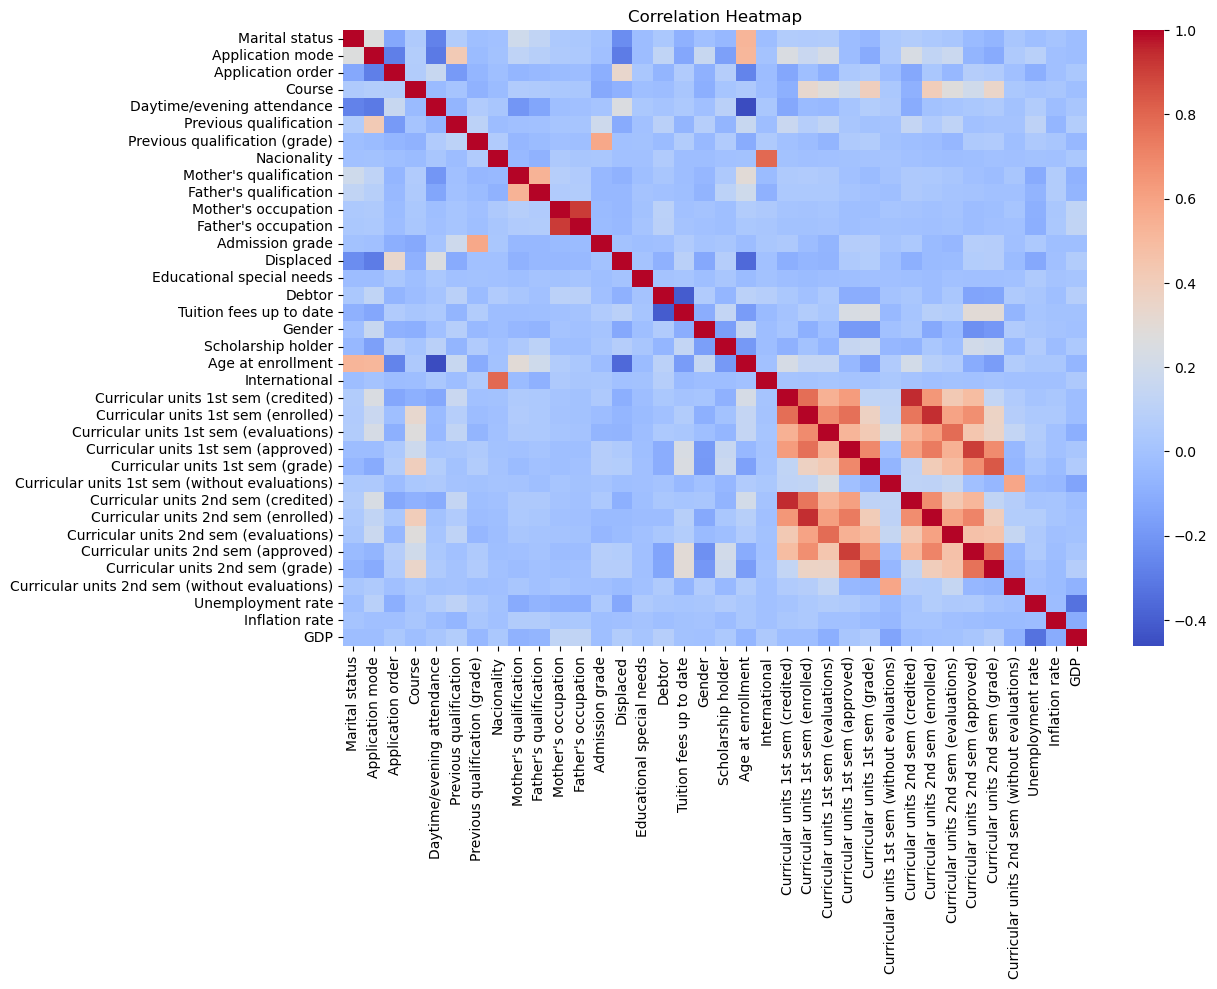

In [7]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [8]:
for c in df.columns:
    print(c, len(df[c].value_counts()))

Marital status 6
Application mode 18
Application order 8
Course 17
Daytime/evening attendance 2
Previous qualification 17
Previous qualification (grade) 101
Nacionality 21
Mother's qualification 29
Father's qualification 34
Mother's occupation 32
Father's occupation 46
Admission grade 620
Displaced 2
Educational special needs 2
Debtor 2
Tuition fees up to date 2
Gender 2
Scholarship holder 2
Age at enrollment 46
International 2
Curricular units 1st sem (credited) 21
Curricular units 1st sem (enrolled) 23
Curricular units 1st sem (evaluations) 35
Curricular units 1st sem (approved) 23
Curricular units 1st sem (grade) 797
Curricular units 1st sem (without evaluations) 11
Curricular units 2nd sem (credited) 19
Curricular units 2nd sem (enrolled) 22
Curricular units 2nd sem (evaluations) 30
Curricular units 2nd sem (approved) 20
Curricular units 2nd sem (grade) 782
Curricular units 2nd sem (without evaluations) 10
Unemployment rate 10
Inflation rate 9
GDP 10
Target 3


# Second step - simple preprocessing and models

In [9]:
# Preprocess the dataset
def prep_df(df):
    """Prepare the dataframe by dropping certain columns, 
    one-hot encoding categorical variables, and standardizing numerical variables."""
    
    # Drop specified columns
    df = df.drop(["Father's occupation", "Mother's occupation"], axis=1) #too many different values
    
    # Columns to one-hot encode
    OH_columns = ["Marital status", "Application mode", "Course", "Previous qualification",
                  "Nacionality", "Mother's qualification", "Father's qualification"]
    
    # Columns to standardize
    ST_columns = ["Previous qualification (grade)", "Admission grade", "Age at enrollment", 
                  "Unemployment rate", "Inflation rate", "GDP"]
    
    # Add all columns that start with "Curricular" to ST_columns
    curricular_columns = [col for col in df.columns if col.startswith("Curricular")]
    ST_columns.extend(curricular_columns)
    
    # One hot encode the specified columns
    df = pd.get_dummies(df, columns=OH_columns, drop_first=True)  
    
    # Standardize the specified columns
    scaler = StandardScaler()
    df[ST_columns] = scaler.fit_transform(df[ST_columns])
    
    return df

In [10]:
# Encode target variable
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(df.Target)
original_targets = label_encoder.transform(df.Target)

# Drop 'Target' column from the dataset
df = df.drop('Target', axis=1)

# Preprocess the dataset
df = prep_df(df)
train = df.copy()
initial_features = list(train.columns)

In [11]:

crossval_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
oof, test_pred = {}, {}


# Define cross-validation function
def cross_validate(model, label, features=initial_features):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.
    """
    start_time = datetime.datetime.now()
    scores = []
    oof_preds = np.full((len(train), 3), np.nan, dtype=float)
    
    for fold, (idx_tr, idx_va) in enumerate(crossval_kf.split(train, targets)):
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = targets[idx_tr]
        y_va = targets[idx_va]

        # Fit the model and predict probabilities
        model.fit(X_tr, y_tr)
        y_pred = model.predict_proba(X_va)
        
        # Compute accuracy score
        score = accuracy_score(y_va, np.argmax(y_pred, axis=1))
        print(f"# Fold {fold}: accuracy={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
            
    elapsed_time = datetime.datetime.now() - start_time
    accuracy = accuracy_score(targets, np.argmax(oof_preds, axis=1))
    logloss = log_loss(targets, oof_preds)
    
    print(f"{Fore.GREEN}# Overall: accuracy={accuracy:.5f}"
          f" logloss={logloss:.5f} {label}"
          f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    
    oof[label] = oof_preds
    


## Cross-validate different models

In [82]:
model = LogisticRegression(multi_class='ovr', max_iter= 1000) 
cross_validate(model, 'Logistic Regression')

# Fold 0: accuracy=0.78531
# Fold 1: accuracy=0.78418
# Fold 2: accuracy=0.76271
# Fold 3: accuracy=0.76045
# Fold 4: accuracy=0.77941
# Overall: accuracy=0.77441 logloss=0.57747 Logistic Regression   0 min


In [83]:
model = RandomForestClassifier()
cross_validate(model, 'Random forest')

# Fold 0: accuracy=0.77514
# Fold 1: accuracy=0.78418
# Fold 2: accuracy=0.78079
# Fold 3: accuracy=0.76497
# Fold 4: accuracy=0.76810
# Overall: accuracy=0.77464 logloss=0.62515 Random forest   0 min


In [84]:
model = xgboost.XGBClassifier(enable_categorical=True)
cross_validate(model, 'XGBoost untuned')

# Fold 0: accuracy=0.77740
# Fold 1: accuracy=0.77288
# Fold 2: accuracy=0.76045
# Fold 3: accuracy=0.75254
# Fold 4: accuracy=0.76357
# Overall: accuracy=0.76537 logloss=0.62196 XGBoost untuned   0 min


/home/asia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [85]:
model =  LGBMClassifier(verbose=0)
cross_validate(model, 'LGBM Classifier')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
# Fold 0: accuracy=0.78192
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
# Fold 1: accuracy=0.77514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
# Fold 2: accuracy=0.76384
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
# Fold 3: accuracy=0.75932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
# Fold 4: accuracy=0.76584
# Overall: accuracy=0.76921 logloss=0.57603 LGBM Classifier   0 min


In [86]:
model =  CatBoostClassifier(verbose=False)
cross_validate(model, 'CatBoost Classifier')

# Fold 0: accuracy=0.77853
# Fold 1: accuracy=0.79209
# Fold 2: accuracy=0.77514
# Fold 3: accuracy=0.76836
# Fold 4: accuracy=0.77036
# Overall: accuracy=0.77690 logloss=0.56156 CatBoost Classifier   1 min


Without tuning and with simple preprocessing, CatBoost showed the highest accuracy, RandomForest is the second best

# Choosing the best model for the competition

## CombinedPreprocessor Class
The CombinedPreprocessor class is responsible for preprocessing dataframes. It helps organize all preprocessing steps and ensures data leakage from the test dataset is avoided. This class offers two preprocessing modes: default and alternative, which can be selected using the method parameter during instantiation.

## Default Mode
* Standardization for Numerical Features: Applies standardization to numerical columns, scaling them to have a mean of 0 and a standard deviation of 1.
* One-Hot Encoding for Categorical Features: Converts categorical columns into binary columns, each representing a single category, while dropping one category to avoid multicollinearity.
* Dropping Categorical Features with Too Many Unique Values: Certain columns are dropped because they have too many unique values, which could lead to a sparse dataset when one-hot encoded.
# Alternative Mode
* Target Encoding for Categorical Features: Encodes categorical columns using target encoding, which replaces each category with a blend of the mean target value for that category and the overall mean target value. This technique can improve model performance by providing more informative features.
* Standardization for Numerical Features: Similar to the default mode, numerical columns are standardized.
## Benefits
* Organized Preprocessing: By encapsulating preprocessing logic within a class, we maintain a clear and organized structure.
* Avoiding Data Leakage: Fitting the transformer only on training data prevents information from the test data from influencing the model during training, thus preventing data leakage.
* Flexibility: The class allows easy switching between different preprocessing methods, enabling experimentation and optimization of preprocessing strategies.

In [12]:
class CombinedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, method='default'):
        self.method = method

        self.default_OH_columns = ["Marital status", "Application mode", "Course", "Previous qualification",
                                   "Nacionality", "Mother's qualification", "Father's qualification"]
        self.default_ST_columns = ["Previous qualification (grade)", "Admission grade", "Age at enrollment", 
                                   "Unemployment rate", "Inflation rate", "GDP"]
        self.default_drop_columns = ["Father's occupation", "Mother's occupation"]

        self.alt_ST_columns = ["Previous qualification (grade)", "Admission grade", "Age at enrollment", 
                               "Unemployment rate", "Inflation rate", "GDP"]
        self.alt_TE_columns = ["Father's occupation", "Mother's occupation", "Marital status", 
                               "Application mode", "Course", "Previous qualification", "Nacionality",
                               "Mother's qualification", "Father's qualification"]

    def fit(self, X, y=None):
        if self.method == 'default':
            self.ST_columns = self.default_ST_columns.copy()
            curricular_columns = [col for col in X.columns if col.startswith("Curricular")]
            self.ST_columns.extend(curricular_columns)
            self.OH_columns = self.default_OH_columns
            self.drop_columns = self.default_drop_columns

            self.preprocessor = ColumnTransformer(
                transformers=[
                    ('drop_cols', 'drop', self.drop_columns),
                    ('num', StandardScaler(), self.ST_columns),
                    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), self.OH_columns)
                ], remainder='passthrough')

            self.preprocessor.fit(X)
            self.feature_names = self.get_feature_names(X)

        elif self.method == 'alternative':
            self.ST_columns = self.alt_ST_columns.copy()
            curricular_columns = [col for col in X.columns if col.startswith("Curricular")]
            self.ST_columns.extend(curricular_columns)
            self.TE_columns = self.alt_TE_columns

            self.preprocessor = ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), self.ST_columns),
                    ('cat', ce.MEstimateEncoder(cols=self.TE_columns, m=1.0), self.TE_columns)
                ], remainder='passthrough')

            self.preprocessor.fit(X, y)
            self.feature_names = self.get_feature_names(X)

        return self

    def transform(self, X):
        if self.method == 'default':
            X_transformed = self.preprocessor.transform(X).toarray()
            X_transformed_df = pd.DataFrame(X_transformed, columns=self.feature_names, index=X.index)
            return X_transformed_df

        elif self.method == 'alternative':
            X_transformed = self.preprocessor.transform(X)
            X_transformed_df = pd.DataFrame(X_transformed, columns=self.feature_names, index=X.index)
            return X_transformed_df

    def get_feature_names(self, X):
        if self.method == 'default':
            num_features = self.ST_columns
            cat_features = self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.OH_columns).tolist()
            feature_names = num_features + cat_features
            remaining_columns = [col for col in X.columns if col not in self.drop_columns + self.ST_columns + self.OH_columns]
            feature_names += remaining_columns

        elif self.method == 'alternative':
            num_features = self.ST_columns
            cat_features = self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.TE_columns).tolist()
            feature_names = num_features + cat_features
            remaining_columns = [col for col in X.columns if col not in self.ST_columns + self.TE_columns]
            feature_names += remaining_columns

        return feature_names


In [13]:
# Load the datasets
df = pd.read_csv('train.csv')
ori = pd.read_csv('data.csv')  # Additional dataset with non-generated data to improve accuracy

# Remove the 'id' column from the training data
df = df.drop('id', axis=1)

# Concatenate the training data with the additional data
df = pd.concat([df, ori])

# Split train and test datasets
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train.Target)
y_test = label_encoder.transform(test.Target)

# Drop the target column from the X
X_train = train.drop('Target', axis=1)
X_test = test.drop('Target', axis=1)

# Instantiate the CombinedPreprocessor with the default method
preprocessor_default = CombinedPreprocessor(method='default')

# Fit the preprocessor on the training data
preprocessor_default.fit(X_train)

# Transform the training and test data using the default preprocessor
X_train_default = preprocessor_default.transform(X_train)
X_test_default = preprocessor_default.transform(X_test)

# Instantiate the CombinedPreprocessor with the alternative method
preprocessor_alternative = CombinedPreprocessor(method='alternative')

# Fit the alternative preprocessor on the training data with the target variable
preprocessor_alternative.fit(X_train, y_train)

# Transform the training and test data using the alternative preprocessor
X_train_alternative = preprocessor_alternative.transform(X_train)
X_test_alternative = preprocessor_alternative.transform(X_test)

/home/asia/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Let's see which preprocessing method results in higher accuracy
We use CatBoostClassifier and LogisticRegression because they showed the highest accuracy in the previous step

In [89]:
# Initialize the classifier
catboost = CatBoostClassifier(silent=True)

# Fit the model on the training data
catboost.fit(X_train_default, y_train)

# Predict on the test data
y_pred_default = catboost.predict(X_test_default)

# Initialize the classifier
catboost = CatBoostClassifier(silent=True)

# Fit the model on the training data
catboost.fit(X_train_alternative, y_train)

# Predict on the test data
y_pred_alternative = catboost.predict(X_test_alternative)

# Calculate the accuracy
accuracy_default = accuracy_score(y_test, y_pred_default)
accuracy_alternative = accuracy_score(y_test, y_pred_alternative)

# Print the accuracy scores
print("Accuracy using default preprocessing: ", accuracy_default)
print("Accuracy using alternative preprocessing: ", accuracy_alternative)

Accuracy using default preprocessing:  0.8347643461609735
Accuracy using alternative preprocessing:  0.8354438198776948


In [90]:
# Initialize the classifier
randomforest = LogisticRegression(multi_class='ovr', max_iter= 1000) 

# Fit the model on the training data
randomforest.fit(X_train_default, y_train)

# Predict on the test data
y_pred_default = randomforest.predict(X_test_default)

# Initialize the classifier
randomforest = RandomForestClassifier()

# Fit the model on the training data
randomforest.fit(X_train_alternative, y_train)

# Predict on the test data
y_pred_alternative = randomforest.predict(X_test_alternative)

# Calculate the accuracy
accuracy_default = accuracy_score(y_test, y_pred_default)
accuracy_alternative = accuracy_score(y_test, y_pred_alternative)

# Print the accuracy scores
print("Accuracy using default preprocessing: ", accuracy_default)
print("Accuracy using alternative preprocessing: ", accuracy_alternative)

Accuracy using default preprocessing:  0.8191364506763852
Accuracy using alternative preprocessing:  0.8284020013589475


In both cases alternative preprocessing results in higher accuracy, so we choose it 

In [44]:
X_train = X_train_alternative.copy()
X_test = X_test_alternative.copy()

## Let's choose the best parameters for each model

## XGBClassifier

In [73]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the classifier
xgb = xgboost.XGBClassifier(tree_method='hist')

# Initialize RandomizedSearchCV with reduced param_grid
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10,
                                   cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_xgb = random_search.best_params_

best_accuracy = random_search.best_score_

print("Best parameters found:", best_params_xgb)
print("Best accuracy on validation set:", best_accuracy)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best accuracy on validation set: 0.829828697233583


## CatBoostClassifier

In [74]:
# Define the parameter grid (reduced for faster processing)
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'colsample_bylevel': [0.8, 1.0]
}

# Initialize the CatBoostClassifier
catboost = CatBoostClassifier(verbose=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=catboost, param_distributions=param_grid, n_iter=8,
                                   cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_catboost = random_search.best_params_
best_accuracy = random_search.best_score_

print("Best parameters found:", best_params_catboost)
print("Best accuracy on validation set:", best_accuracy)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'learning_rate': 0.1, 'iterations': 200, 'depth': 5, 'colsample_bylevel': 1.0}
Best accuracy on validation set: 0.8258999512666242


## RandomForestClassifier

In [72]:
# Define the parameter grid (reduced for faster processing)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None] 
}

# Initialize the RandomForestClassifier
randomforest = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=randomforest, param_distributions=param_grid, n_iter=8,
                                   cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_randomforest = random_search.best_params_
best_accuracy = random_search.best_score_

print("Best parameters found:", best_params_randomforest)
print("Best accuracy on validation set:", best_accuracy)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Best accuracy on validation set: 0.8221318213046297


## HistGradientBoosting

In [75]:
# Define the parameter grid (reduced for faster processing)
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 5],
    'min_samples_leaf': [10, 20],
    'l2_regularization': [0.0, 0.1]
}

# Initialize the HistGradientBoostingClassifier
hgb_model = HistGradientBoostingClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=hgb_model, param_distributions=param_grid, n_iter=8,
                                   cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_hgb = random_search.best_params_
best_accuracy = random_search.best_score_

print("Best parameters found:", best_params_hgb)
print("Best accuracy on validation set:", best_accuracy)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'min_samples_leaf': 20, 'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1, 'l2_regularization': 0.1}
Best accuracy on validation set: 0.8300757929325422


## LGBM

In [76]:
# Define the parameter grid (reduced for faster processing)
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [-1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_samples': [10, 20],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.1]
}

# Initialize the LGBMClassifier
lgbm_model = LGBMClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid, n_iter=8,
                                   cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_lgbm = random_search.best_params_
best_accuracy = random_search.best_score_

print("Best parameters found:", best_params_lgbm)
print("Best accuracy on validation set:", best_accuracy)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1410
[LightGBM] [Info] Number of data points in the train set: 80942, number of used features: 36
[LightGBM] [Info] Start training from score -1.108433
[LightGBM] [Info] Start training from score -1.637909
[LightGBM] [Info] Start training from score -0.743308
Best parameters found: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_est

# Stacking

In [47]:

# Initialize base classifiers
model_1 = LGBMClassifier(**best_params_lgbm)
model_2 = xgboost.XGBClassifier(**best_params_xgb)
model_3 = RandomForestClassifier(**best_params_randomforest)
model_4 = HistGradientBoostingClassifier(**best_params_hgb)
model_5 = CatBoostClassifier(**best_params_catboost)

# Define the base models as a list of tuples
base_models = [
    ('lgbm', model_1),
    ('xgb', model_2),
    ('rf', model_3),
    ('hgb', model_4),
    ('catboost', model_5)
]

# Define the meta-classifier
meta_classifier = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier)

stacking_clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1403
[LightGBM] [Info] Number of data points in the train set: 64753, number of used features: 36
[LightGBM] [Info] Start training from score -1.107984
[LightGBM] [Info] Start training from score -1.637280
[LightGBM] [Info] Start training from score -0.743877
0:	learn: 0.9955123	total: 35.8ms	remaining: 7.13s
1:	learn: 0.9190174	total: 72ms	remaining: 7.13s
2:	learn: 0.8554704	total: 113ms	remaining: 7

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [49]:
# Predict on the test data
y_pred = stacking_clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.8356291308913459


# Fitting the final model to the whole training set and submiting the result

In [62]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ori = pd.read_csv('data.csv')  # Additional dataset with non-generated data to improve accuracy

# Remove the 'id' column from the data
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
# Concatenate the training data with the additional data
train = pd.concat([train, ori])

# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train.Target)

# Drop the target column from the training data
X_train = train.drop('Target', axis=1)
X_test = test.copy()

# Instantiate the CombinedPreprocessor with the alternative method
preprocessor = CombinedPreprocessor(method='alternative')

# Fit the alternative preprocessor on the training data with the target variable
preprocessor.fit(X_train, y_train)

# Transform the training and test data using the alternative preprocessor
X_train = preprocessor_alternative.transform(X_train)
X_test = preprocessor_alternative.transform(X_test)

In [64]:
# Initialize base classifiers
model_1 = LGBMClassifier(**best_params_lgbm)
model_2 = xgboost.XGBClassifier(**best_params_xgb)
model_3 = RandomForestClassifier(**best_params_randomforest)
model_4 = HistGradientBoostingClassifier(**best_params_hgb)
model_5 = CatBoostClassifier(**best_params_catboost)

# Define the base models as a list of tuples
base_models = [
    ('lgbm', model_1),
    ('xgb', model_2),
    ('rf', model_3),
    ('hgb', model_4),
    ('catboost', model_5)
]

# Define the meta-classifier
meta_classifier = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier)
stacking_clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1410
[LightGBM] [Info] Number of data points in the train set: 80942, number of used features: 36
[LightGBM] [Info] Start training from score -1.108433
[LightGBM] [Info] Start training from score -1.637909
[LightGBM] [Info] Start training from score -0.743308
0:	learn: 0.9949541	total: 74.2ms	remaining: 14.8s
1:	learn: 0.9189514	total: 157ms	remaining: 15.5s
2:	learn: 0.8554046	total: 254ms	remaining: 

/home/asia/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(max_depth=10,
                                               min_child_samples=10,
                                               n_estimators=200, reg_alpha=0.1,
                                               reg_lambda=0.1, subsample=0.8)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_...
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier(n_estimators=200)),
                               ('hgb',
                                HistGradientBoostingClassifier(l2_regularization=0.1,
                                                               max_depth=5,
                                                               max_iter=200)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x73f1b0046e00>)],
                   final_estimator=LogisticRegression())

In [67]:
y_pred = stacking_clf.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
res = pd.read_csv('sample_submission.csv')
res.Target = y_pred_labels
res.to_csv('res.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [68]:
# Access the coefficients of the meta-classifier (LogisticRegression)
meta_classifier_coefs = stacking_clf.final_estimator_.coef_

# Extract feature names or model names
model_names = [name for name, _ in base_models]

# Create a dictionary to store model coefficients
model_importance = dict(zip(model_names, meta_classifier_coefs[0]))

# Print or analyze model importance
print("Model Importance based on Logistic Regression Coefficients:")
for model, importance in model_importance.items():
    print(f"{model}: {importance}")

Model Importance based on Logistic Regression Coefficients:
lgbm: 1.3039720627423828
xgb: -0.6778161229844394
rf: -0.6121100847228723
hgb: -0.537878883255535
catboost: 0.40413835413562343


## Another way of stacking the models

In [71]:
# Create the Voting Classifier
voting_model = VotingClassifier(estimators=base_models, voting='soft', weights=None)

# Fit the Voting Classifier
voting_model.fit(X_train, y_train)

# Predict on X_test
y_pred = voting_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
res = pd.read_csv('sample_submission.csv')
res.Target = y_pred_labels
res.to_csv('res.csv', index=False)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1410
[LightGBM] [Info] Number of data points in the train set: 80942, number of used features: 36
[LightGBM] [Info] Start training from score -1.108433
[LightGBM] [Info] Start training from score -1.637909
[LightGBM] [Info] Start training from score -0.743308
0:	learn: 0.9949541	total: 46.1ms	remaining: 9.17s
1:	learn: 0.9189514	total: 90.2ms	remaining: 8.93s
2:	learn: 0.8554046	total: 131ms	remaining:

In [ ]:
# Define the Voting Classifier without specifying weights initially
voting_model = VotingClassifier(estimators=base_models, voting='soft')

# Define the parameter grid for weights
param_grid = {
    'weights': [
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 2],
        [1, 1, 1, 2, 1],
        [1, 1, 2, 1, 1],
        [1, 2, 1, 1, 1],
        [2, 1, 1, 1, 1],
        [2, 2, 1, 1, 1],
        [2, 1, 2, 1, 1],
        [1, 2, 2, 1, 1],
        [1, 1, 2, 2, 1],
        [1, 1, 1, 2, 2],
        [1, 1, 2, 1, 2],
        [1, 2, 1, 1, 2],
        [2, 1, 1, 1, 2],
        [2, 2, 2, 1, 1],
        [2, 2, 1, 2, 1],
        [2, 1, 2, 2, 1],
        [1, 2, 2, 2, 1],
        [1, 1, 2, 2, 2],
        [1, 2, 1, 2, 2],
        [2, 1, 1, 2, 2],
        [2, 2, 2, 2, 1],
        [2, 2, 2, 1, 2],
        [2, 2, 1, 2, 2],
        [2, 1, 2, 2, 2],
        [1, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]
    ]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=voting_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters found by grid search
best_weights = grid_search.best_params_['weights']
print("Best weights:", best_weights)

# Create the Voting Classifier with the best weights
voting_model = VotingClassifier(estimators=base_models, voting='soft', weights=best_weights)

# Fit the Voting Classifier
voting_model.fit(X_train, y_train)

# Predict on X_test
y_pred = voting_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
res = pd.read_csv('sample_submission.csv')
res.Target = y_pred_labels
res.to_csv('res.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 64753, number of used features: 36
[LightGBM] [Info] Start training from score -1.108405
[LightGBM] [Info] Start training from score -1.637915
[LightGBM] [Info] Start training from score -0.743325
0:	learn: 0.9954183	total: 41.5ms	remaining: 8.25s
1:	learn: 0.9189003	total: 81.2ms	remaining: 8.03s
2:	learn: 0.8560220	total: 120ms	remaining:

In [15]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
for score, name in zip(randomforest.feature_importances_, X_train.columns):
    print(round(score, 2), name)

0.0 Marital status
0.02 Application mode
0.01 Application order
0.02 Course
0.0 Daytime/evening attendance
0.0 Previous qualification
0.03 Previous qualification (grade)
0.0 Nacionality
0.02 Mother's qualification
0.02 Father's qualification
0.02 Mother's occupation
0.02 Father's occupation
0.04 Admission grade
0.01 Displaced
0.0 Educational special needs
0.01 Debtor
0.03 Tuition fees up to date
0.01 Gender
0.02 Scholarship holder
0.03 Age at enrollment
0.0 International
0.0 Curricular units 1st sem (credited)
0.01 Curricular units 1st sem (enrolled)
0.04 Curricular units 1st sem (evaluations)
0.12 Curricular units 1st sem (approved)
0.08 Curricular units 1st sem (grade)
0.0 Curricular units 1st sem (without evaluations)
0.0 Curricular units 2nd sem (credited)
0.01 Curricular units 2nd sem (enrolled)
0.05 Curricular units 2nd sem (evaluations)
0.19 Curricular units 2nd sem (approved)
0.1 Curricular units 2nd sem (grade)
0.0 Curricular units 2nd sem (without evaluations)
0.02 Unemployme